# Classification of junD binding

**Authorship:**
Adam Klie, *08/07/2022*
***
**Description:**
This notebook is a use case in EUGENe paper. It is used to showcase Janggu integrated functionality to classify junD binding sites.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import os
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jund"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jund" 
eu.settings.dl_num_workers = 4
eu.settings.batch_size = 64

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000
0.1.0


# Data Extraction

In [2]:
sdata = eu.dl.read_h5sd(
    filename=os.path.join(eu.settings.dataset_dir, "kopp21", "junD", "jund_processed.h5sd"),
)

In [3]:
sdata

SeqData object with = 1013080 seqs
seqs = (1013080,)
names = (1013080,)
rev_seqs = (1013080,)
ohe_seqs = (1013080, 500, 4)
ohe_rev_seqs = (1013080, 500, 4)
seqs_annot: 'chr', 'end', 'seq_len', 'start', 'target'
pos_annot: None
seqsm: None
uns: None

# Data Visualization

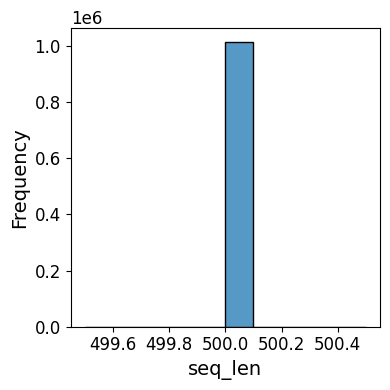

In [8]:
# Double check that the sequences are the same length
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h",
    bins=10,
    figsize=(4,4)
)

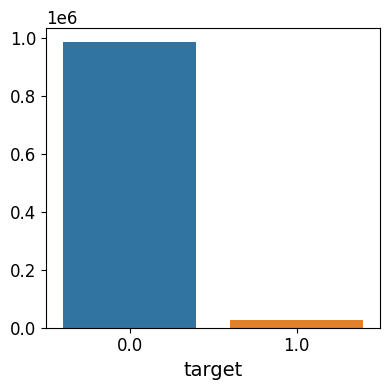

In [9]:
# See the distribution of sequence labels, its clear we have some unbalanced classes
eu.pl.countplot(
    sdata,
    keys="target",
    figsize=(4,4)
)

In [16]:
# Fix this!!!
sdata["chr"] = sdata["chr"].str.decode("utf-8")

In [19]:
def Set_Chr_Nr_ (Chr):
    """ Sort by chromosome """
    if Chr: 
        New = Chr[3:]
        if New == 'X': New = 23
        elif New == 'Y': New = 24
        elif New == 'M': New = 25
        else: New = int(New)
    else:
        New = 0
    return New

In [23]:
ord = sorted(np.unique(sdata["chr"].values), key=lambda x: Set_Chr_Nr_(x))

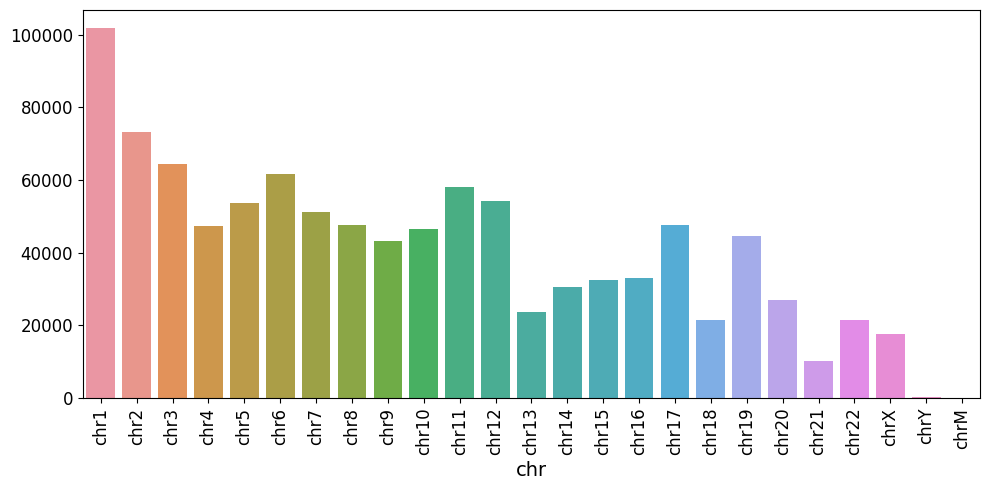

In [24]:
# Check the distribution of sequences on chromosomes
eu.pl.countplot(
    sdata,
    keys="chr",
    xtick_rot=90,
    order=ord
)

# Preprocessing

In [25]:
# Split into train and test sets
eu.pp.train_test_split_data(
    sdata, 
    train_key="train_test",
    chr = ["chr3"]
)

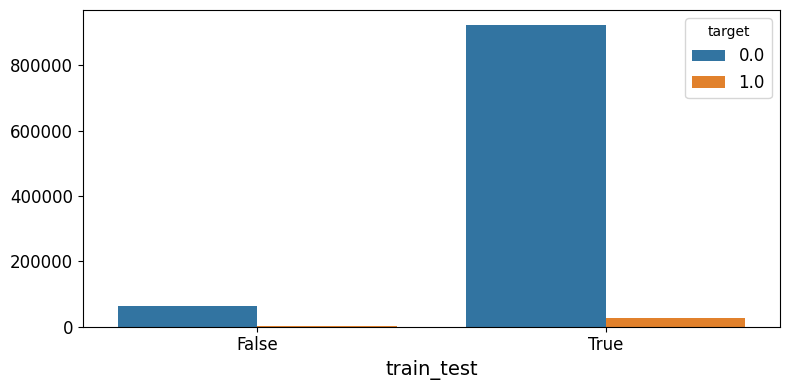

In [28]:
# Double check to make sure the pslit looks decent
eu.pl.countplot(
    sdata,
    keys="train_test",
    hue="target",
    figsize=(8,4)
)

In [29]:
# Split into training and test sets
sdata_train = sdata[sdata["train_test"].values]
sdata_test = sdata[~sdata["train_test"].values]

In [30]:
# Split the training sequences into train and validation sets
eu.pp.train_test_split_data(
    sdata_train,
    train_key="train_val",
    chr=["chr2"]
)

SeqData object modified:
    seqs_annot:
        + train_val


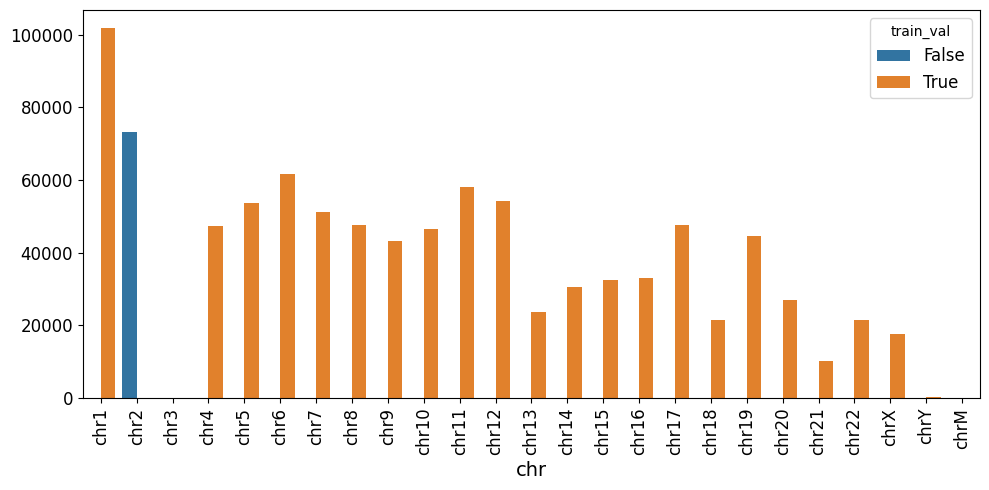

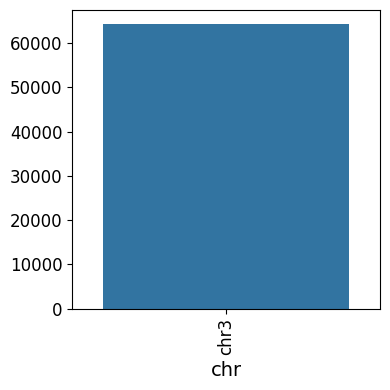

In [33]:
# Check the distribution of sequences on chromosomes
eu.pl.countplot(
    sdata_train,
    keys="chr",
    hue="train_val",
    xtick_rot=90,
    order=ord
)
# Check the distribution of sequences on chromosomes
eu.pl.countplot(
    sdata_test,
    keys="chr",
    xtick_rot=90,
    figsize=(4,4),
)

# Training

In [ ]:
# TODO: Instantiate your model
model = eu.models.load_config(
    arch="CNN", 
    model_config="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/junD/ssCNN.yaml"
)

In [ ]:
# TODO: Initialize your models parameters
eu.models.base.init_weights(model)

In [79]:
model = eu.models.Kopp21CNN(
    input_len=500,
    output_dim=1,
    optimizer_kwargs={"amsgrad": True}
)
eu.models.base.init_weights(model)
model.summary()

Model: Kopp21CNN
Input length: 500
Output dimension: 1
Strand: ds
Task: binary_classification
Aggregation: max
Loss function: binary_cross_entropy_with_logits
Optimizer: adam
Learning rate: 0.001
Scheduler: lr_scheduler
Scheduler patience: 2


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  | Name       | Type        | Params
-------------------------------------------
0 | hp_metric  | AUROC       | 0     
1 | conv       | Conv1d      | 450   
2 | maxpool    | MaxPool1d   | 0     
3 | batchnorm  | BatchNorm1d | 20    
4 | conv2      | Conv1d      | 248   
5 | batchnorm2 | BatchNorm1d | 16    
6 | linear     | Linear      | 9     
-------------------------------------------
743       Trainable params
0         Non-trainable params
743       Total params
0.003     Total estimated model params size (MB)

In [80]:
model.configure_optimizers()

{'optimizer': Adam (
 Parameter Group 0
     amsgrad: True
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'lr_scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x1554742ad610>,
 'monitor': 'val_loss'}

In [81]:
# Just make sure the model is taking in the proper data
sdata_sub = sdata_train[np.random.choice(np.arange(len(sdata_train.names)), size=(2000))]
sdataloader_sub = sdata_sub.to_dataset(transform_kwargs={"transpose": True}).to_dataloader()
test_seqs = next(iter(sdataloader_sub))
model(test_seqs[1], test_seqs[2]).size()

No transforms given, assuming just need to tensorize).


torch.Size([128, 1])

In [82]:
eu.train.fit(
    model=model, 
    sdata=sdata_train, 
    target="target",
    train_key="train_val",
    epochs=30,
    gpus=1,
    early_stopping_metric="val_loss",
    early_stopping_patience=5,
    version=f"v0"
)

No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type        | Params
-------------------------------------------
0 | hp_metric  | AUROC       | 0     
1 | conv       | Conv1d      | 450   
2 | maxpool    | MaxPool1d   | 0     
3 | batchnorm  | BatchNorm1d | 20    
4 | conv2      | Conv1d      | 248   
5 | batchnorm2 | BatchNorm1d | 16    
6 | linear     | Linear      | 9     
-------------------------------------------
743       Trainable params
0         Non-trainable params
743       Total params
0.003     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.093


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.092


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.091


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.090


RuntimeError: DataLoader worker (pid(s) 3773624, 3773625, 3773626, 3773627) exited unexpectedly

We can see how well our models trained by plotting a training summary:

```python
eu.train.pl_training_summary(model_leaf, version=f"v1")
```

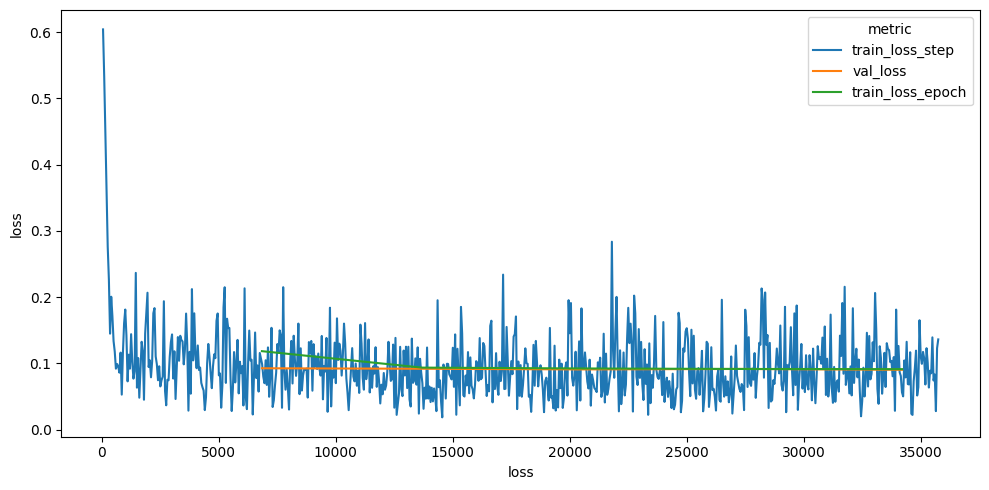

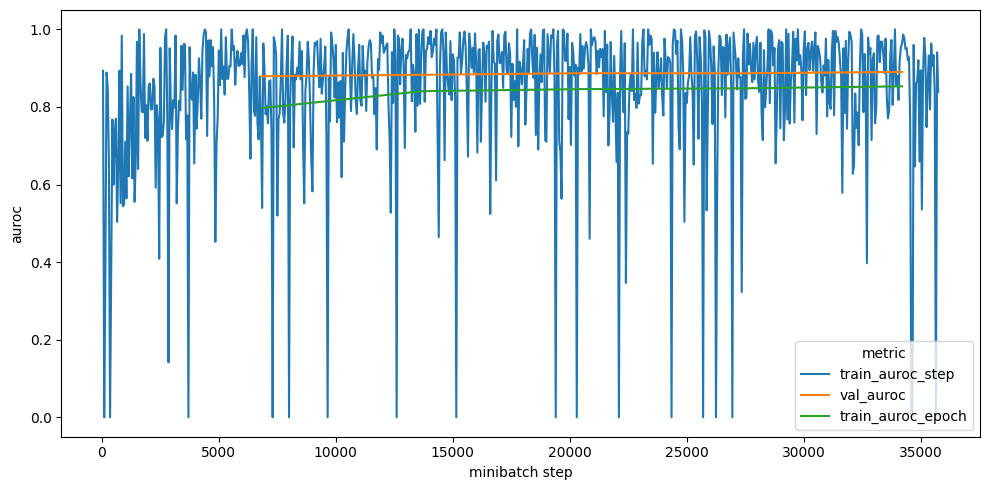

In [84]:
eu.pl.training_summary(
    log_path=os.path.join(eu.settings.logging_dir, "dsKopp21CNN_binary_classification", "v0"),
    metrics="auroc"
)

# Evaluation

In [86]:
# Load in the best model from checkpoint
best_model = eu.models.Kopp21CNN.load_from_checkpoint("/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jund/dsKopp21CNN_binary_classification/v0/checkpoints/epoch=4-step=34204.ckpt")

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [87]:
# Get predictions on the training and val sets
eu.predict.train_val_predictions(
    best_model,
    sdata=sdata_train,
    target="target",
    train_key="train_val",
    version="v0"
)

No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + target_predictions


In [88]:
# Predict on test set
eu.predict.predictions(
    best_model,
    sdata=sdata_test,
    target="target",
    version="v0",
    file_label="test"
)

No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + target_predictions


In [93]:
# Grab indeces for train and val
train_idx = np.where(sdata_train["train_val"] == True)[0]
val_idx = np.where(sdata_train["train_val"] == False)[0]

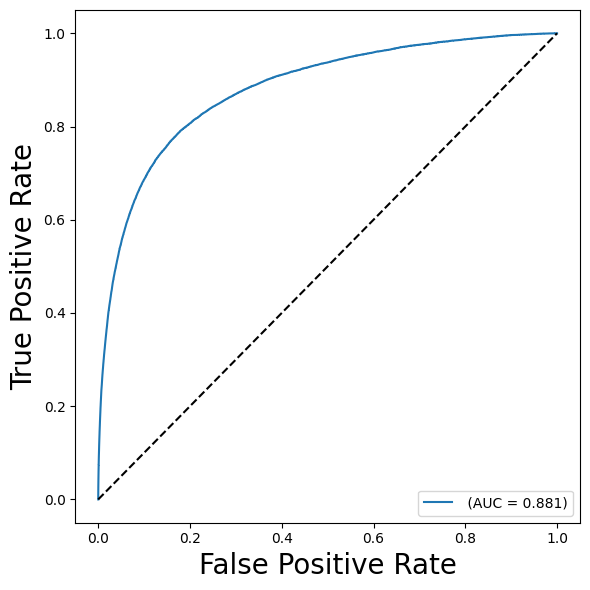

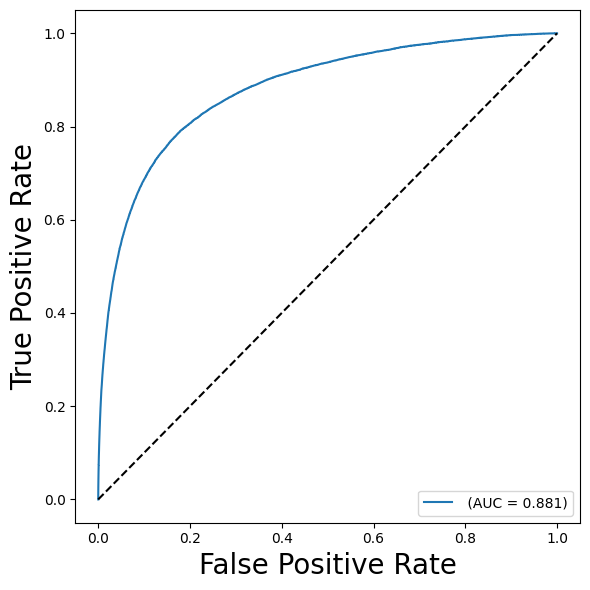

In [97]:
# Plot train and val auprcs
eu.pl.auroc(sdata=sdata_train, idx=train_idx, targets="target", predictions="target_predictions")
eu.pl.auroc(sdata=sdata_train, idx=val_idx, targets="target", predictions="target_predictions")

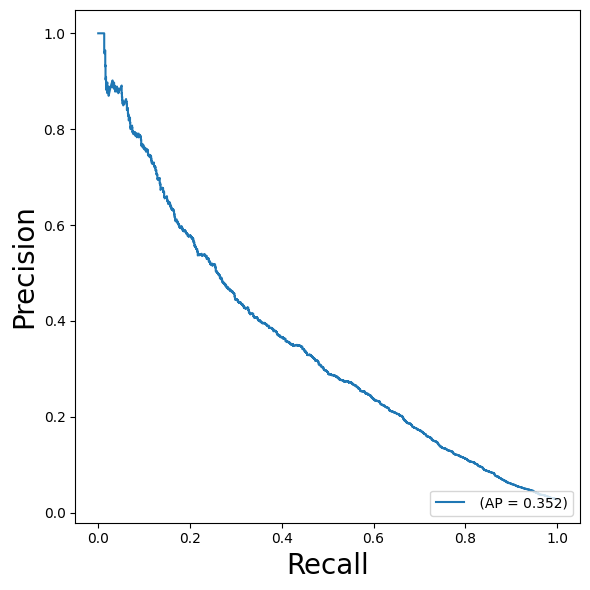

In [134]:
# Plot test auprcs
eu.pl.auprc(
    sdata_test,
    targets="target",
    predictions="target_predictions"
)

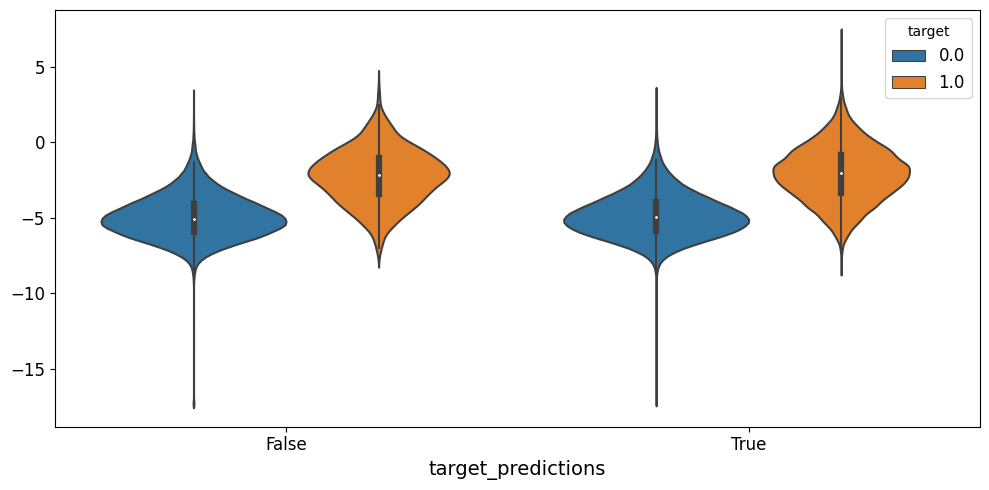

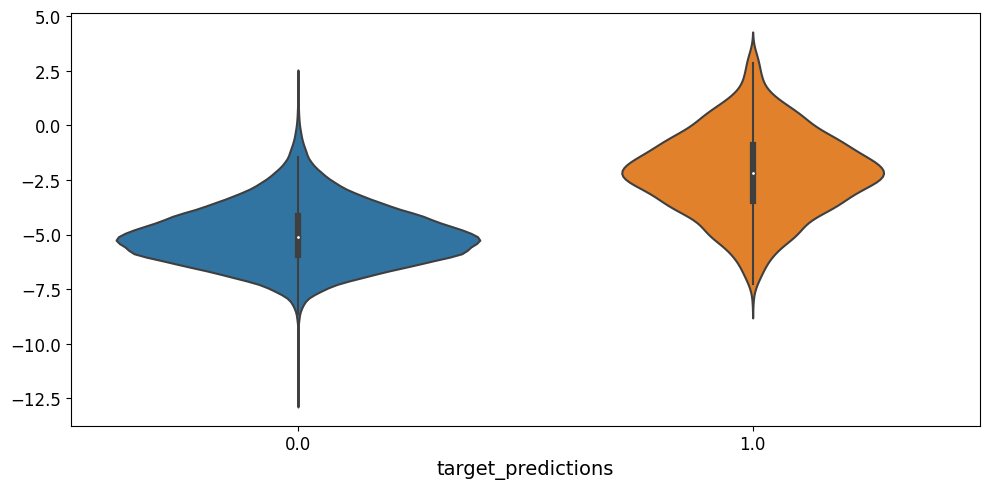

In [99]:
# Look at the distributions
eu.pl.violinplot(sdata_train, keys="target_predictions", groupby="train_val", hue="target")
eu.pl.violinplot(sdata_test, keys="target_predictions", groupby="target")

In [101]:
from sklearn.preprocessing import binarize

In [107]:
np.unique(binarize(sdata_test["target_predictions"].values.reshape(-1, 1), threshold=-3), return_counts=True)

(array([0., 1.]), array([57882,  6427]))

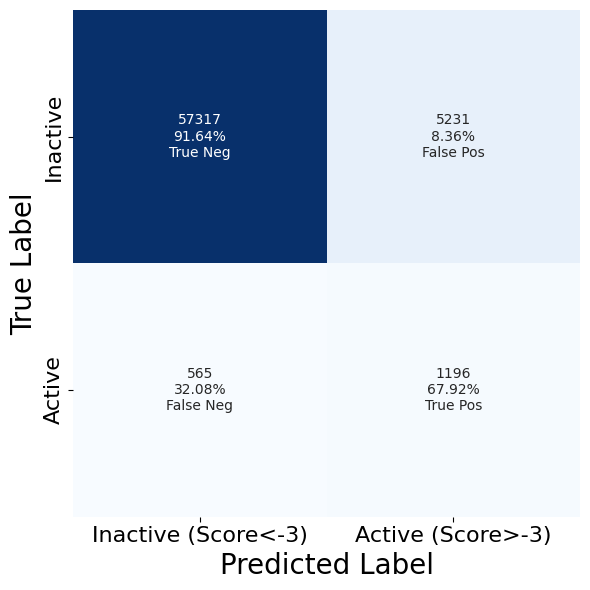

In [108]:
eu.pl.confusion_mtx(
    sdata_test,
    target="target",
    prediction="target_predictions",
    threshold=-3
)

# Interpretation

## Feature attribution

In [109]:
# TODO: Run feature attribution on your model
eu.interpret.feature_attribution(
    best_model,
    sdata_test,
    saliency_method="InputXGradient",
    device="cuda" if eu.settings.gpus > 0 else "cpu"
)

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/502 [00:00<?, ?it/s]

In [110]:
roi = sdata_test[(sdata_test["start"] >= 2354500) & (sdata_test["end"] <= 2356000)].names

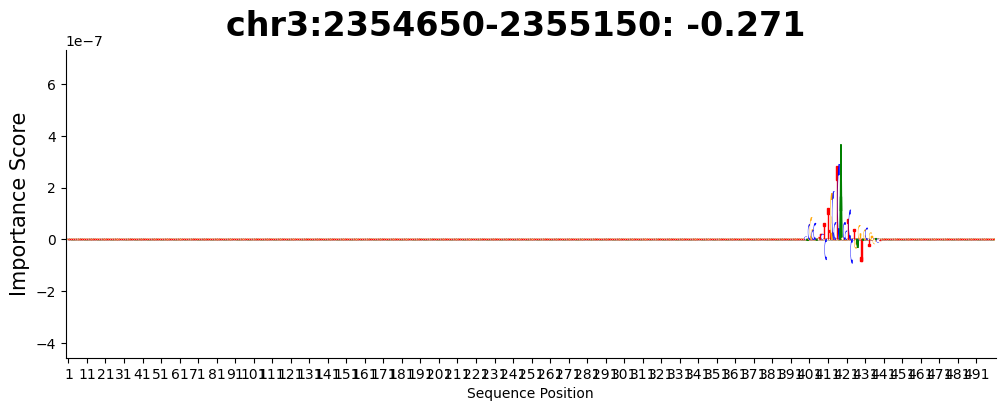

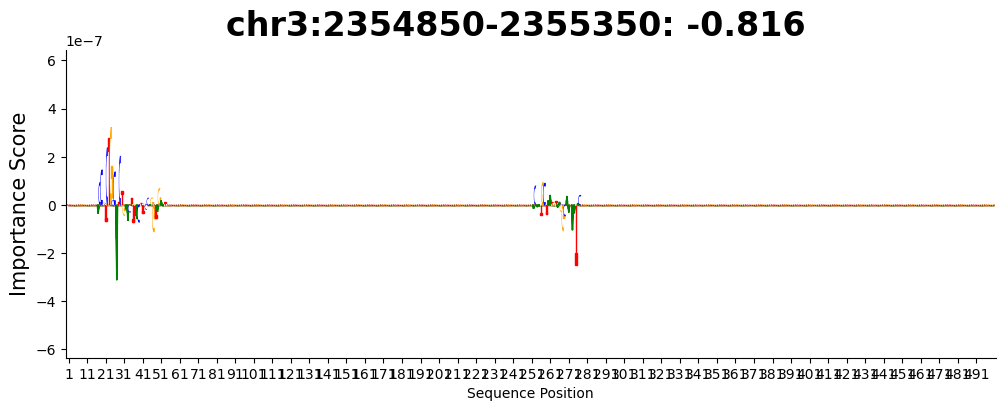

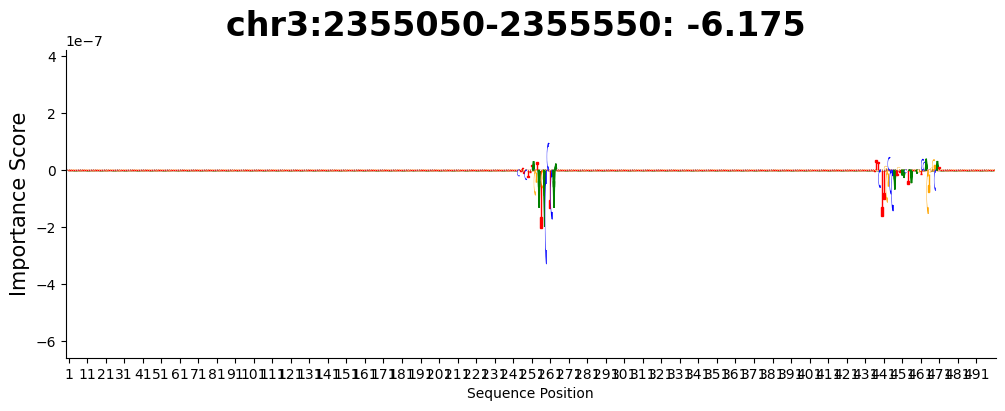

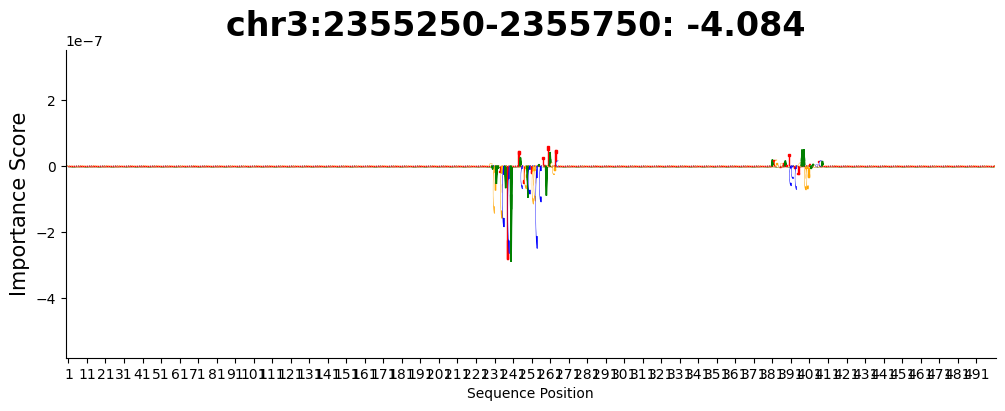

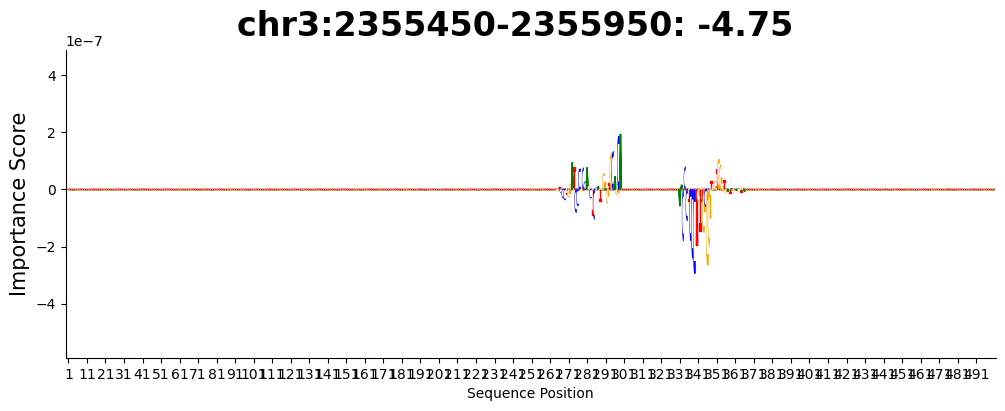

In [111]:
for seq in roi:
    eu.pl.seq_track(
        sdata_test,
        seq_id=seq,
        uns_key="InputXGradient_imps",
        pred_key="target_predictions"
    )

In [39]:
highest_5 = sdata_test["target_predictions"].sort_values(ascending=False).index[:5]

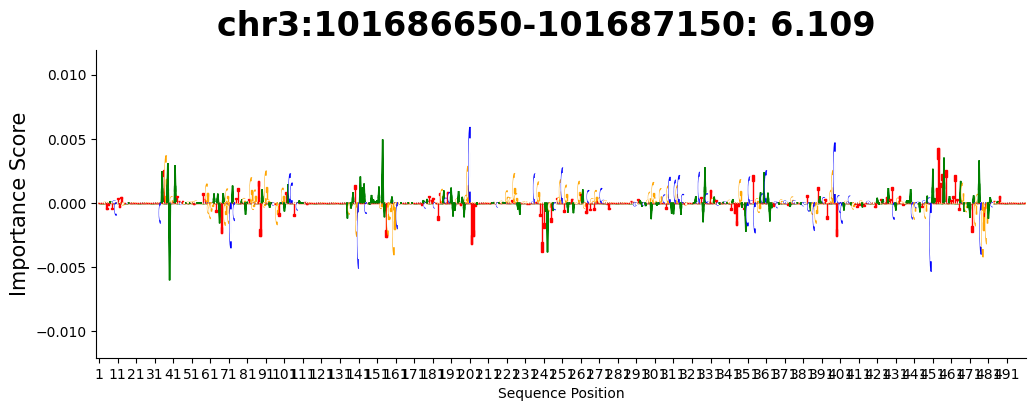

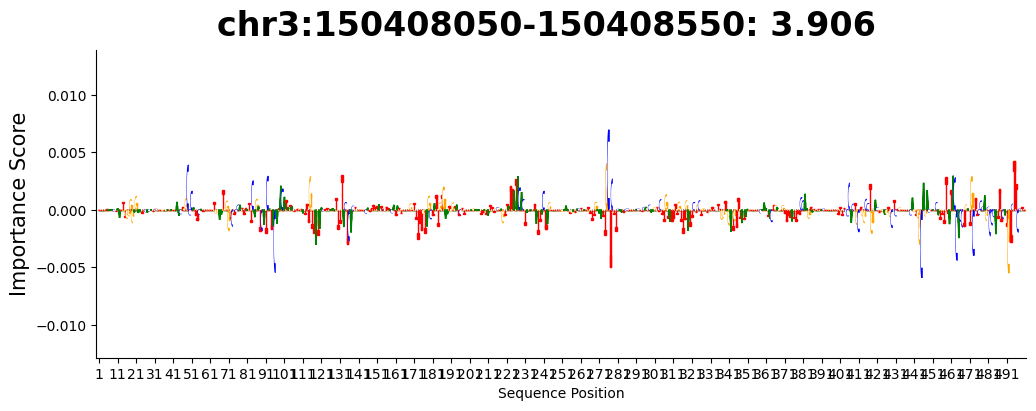

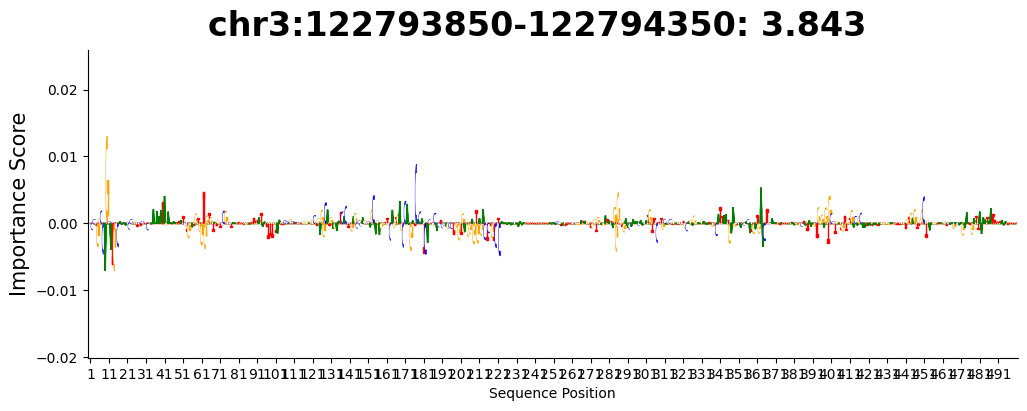

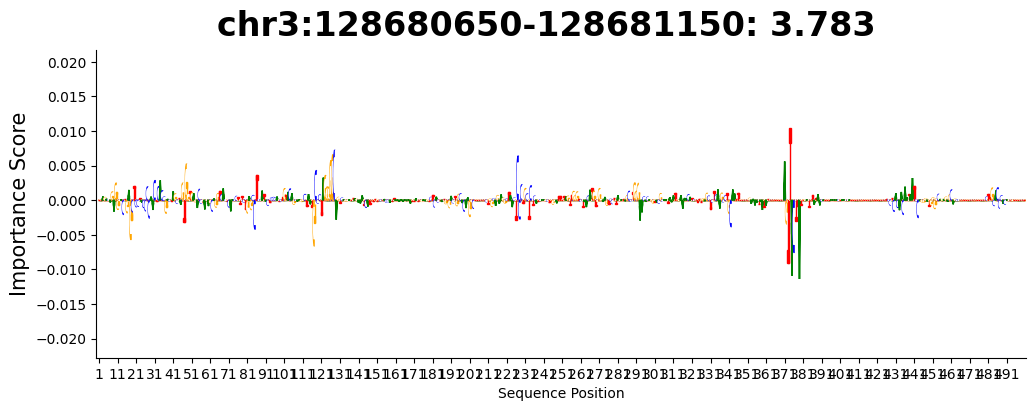

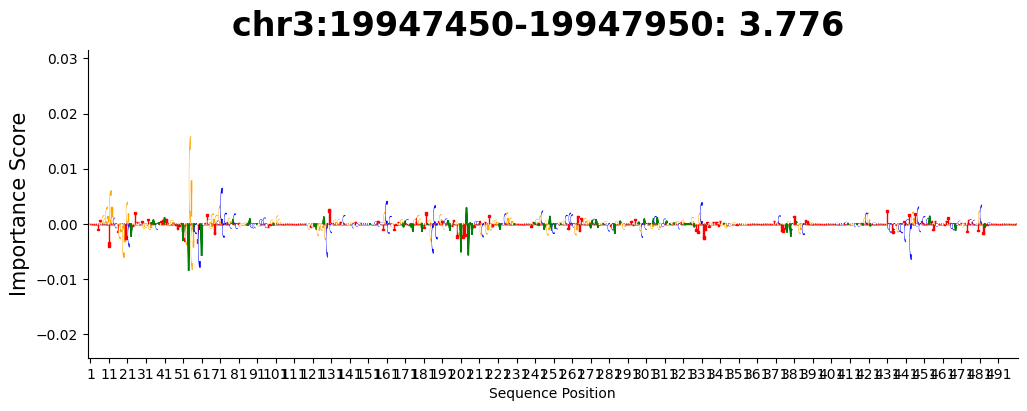

In [40]:
for seq in highest_5:
    eu.pl.seq_track(
        sdata_test,
        seq_id=seq,
        uns_key="DeepLift_imps",
        pred_key="target_predictions"
    )

## Filter Visualization 
We can get an idea for what each filter of first convoulional layer of the model is seeing by using the `interpret` module's `generate_pfms` function. This creates a position frequency matrix for each filter in the model using sequences that highly activate that filter (can be defined in multiple ways). We often times pass the the test sequences through the model, but you can theoretically pass any sequences you want.
```python
eu.interpret.generate_pfms(
    best_model, 
    sdata_test
)
```

In [ ]:
eu.interpret.generate_pfms(best_model, sdata_test)

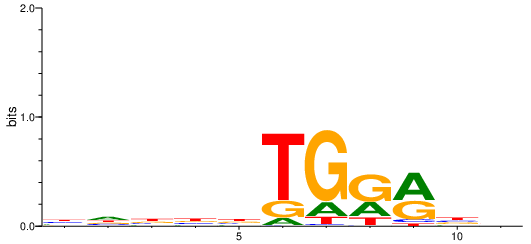

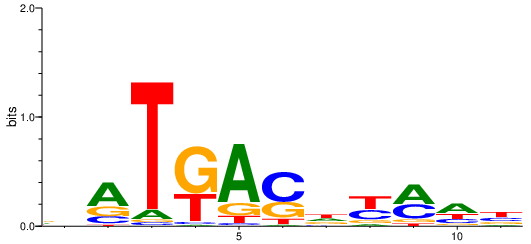

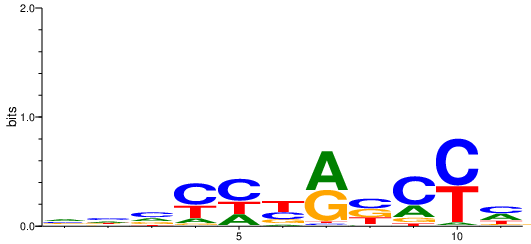

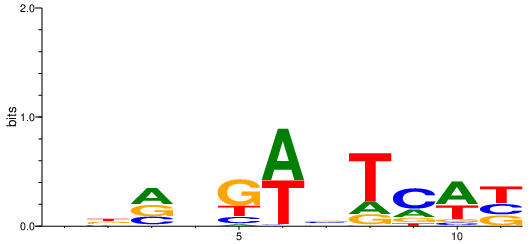

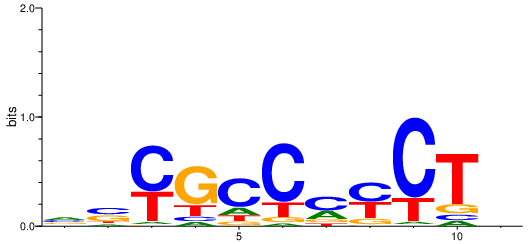

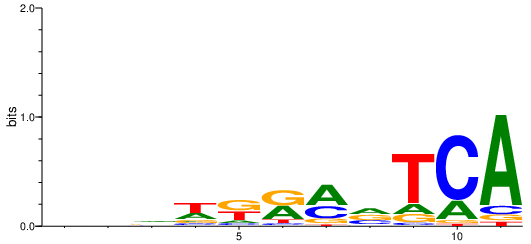

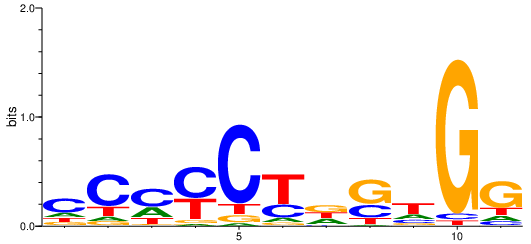

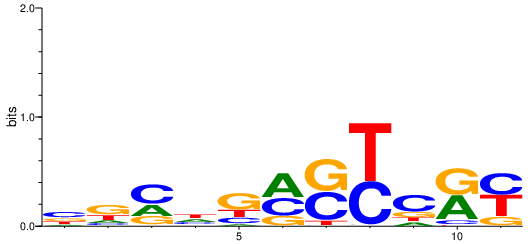

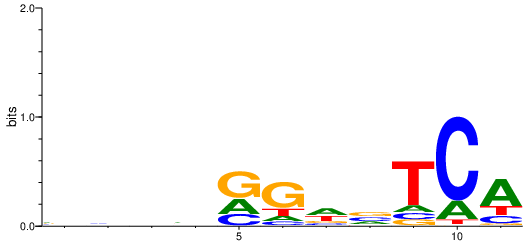

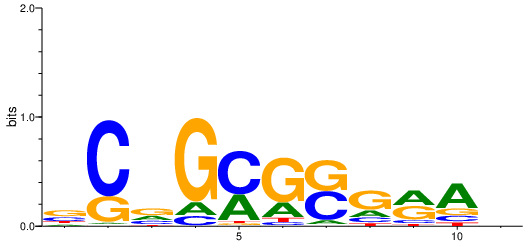

In [133]:
for i in range(10):
    eu.pl.filter_viz(
        sdata_test,
        filter_id=i
    )

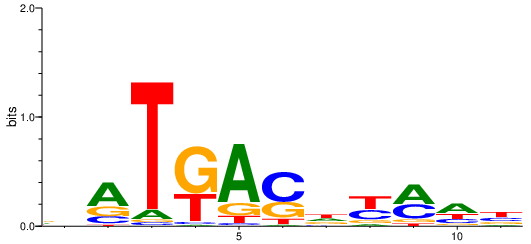

In [129]:
eu.pl.filter_viz(
    sdata_test,
    filter_id=1
)

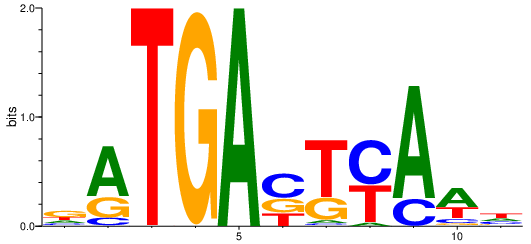

In [29]:
# Previous filter viz
eu.pl.filter_viz(
    sdata_test,
    filter_id=2
)

## Other intepretation methods
We currently implement a few other methods for interpreting the model's predictions. These include:
- Dimensionality Reduction on your importance scores: e.g. `eu.interpret.pca`
- ...
We are looking to add more! If you are interested in contributing...

In [ ]:
# TODO: Perform other intepretation methods on your trained model

# Wrapping up
EUGENe is very much meant to be a community project. It represents a collection of data, models, and techniques meant for analyzing sequence data with deep learning. We are looking for contributions in almost every aspect of EUGENe. We are particularly interested in:

- New model additions through the `models` module
- New dataset additions through the `datasets` module
- New preprocessing techniques through the `preprocessing` module
- New visualization techniques through the `plotting` module
- New interpretation techniques through the `interpret` module
- New methods for training models in the `train` module

Please do not hesitate to contact us if you have any questions or suggestions.

---